In [516]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [ ]:
pd.set_option('display.max_columns', 120)

todo - заполнить пропуски
todo - собрать стату поклиентам (не для холодного старта)

# Download data

In [470]:
interactions = pd.read_csv('/Users/dan/Desktop/Python/Project 1yMOVS/Data/interactions.csv', sep=',')

In [471]:
items = pd.read_csv('/Users/dan/Desktop/Python/Project 1yMOVS/Data/items.csv', sep=',')

In [472]:
users = pd.read_csv('/Users/dan/Desktop/Python/Project 1yMOVS/Data/users.csv', sep=',')

# users

In [473]:
users.head()

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0


In [474]:
# Проверим кол-во пропусков
users.isna().sum() / len(users)

user_id     0.000000
age         0.016776
income      0.017586
sex         0.016462
kids_flg    0.000000
dtype: float64

Гепотиза - на основе возроста можно предсказать доход

In [475]:
# Какие данные есть у пользователей с пропущенным income
users[users['income'].isna()].isna().sum()

user_id         0
age         12243
income      14776
sex          8796
kids_flg        0
dtype: int64

практически у всех пользователей с пропусками в income отсутсвует и возраст. Заполнить не получится.

___Заполним модой пропуски___

Вместо None у нас значение nan с типом float - поэтому костылю перебором строчек

In [476]:
inc_moda = users['income'].mode()
for row in tqdm(range(len(users))):
    if type(users['income'].loc[row]) != str:
        users['income'].loc[row] = inc_moda[0]

100%|█████████████████████████████████████████████████████████████████████████| 840197/840197 [00:30<00:00, 27422.37it/s]


In [477]:
age_moda = users['age'].mode()
for row in tqdm(range(len(users))):
    if type(users['age'].loc[row]) != str:
        users['age'].loc[row] = age_moda[0]

100%|█████████████████████████████████████████████████████████████████████████| 840197/840197 [00:26<00:00, 31241.93it/s]


In [478]:
sex_moda = users['sex'].mode()
for row in tqdm(range(len(users))):
    if type(users['sex'].loc[row]) != str:
        users['sex'].loc[row] = sex_moda[0]

100%|█████████████████████████████████████████████████████████████████████████| 840197/840197 [00:28<00:00, 29203.44it/s]


In [479]:
users.isna().sum().sum()

0

___Категориальные переменные в бинарные___

In [480]:
users['gender_man_flg'] = users['sex'].apply(lambda x: 1 if x=='М' else 0)
users = users.drop('sex', axis=1)

In [481]:
# Фичи, которые будем преобразовывать
encod_features = ['age', 'income']

# Получим новый df с преобразованными фичами
encoder = OneHotEncoder(sparse=False)
df_encoded_features = pd.DataFrame(encoder.fit_transform(users[encod_features]))
df_encoded_features.columns = encoder.get_feature_names_out()

df_encoded_features.head()

,age_age_18_24,age_age_25_34,age_age_35_44,age_age_45_54,age_age_55_64,age_age_65_inf,income_income_0_20,income_income_150_inf,income_income_20_40,income_income_40_60,income_income_60_90,income_income_90_150
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [482]:
# Заменим категориальные фичи на новые бинаризованные.
users = pd.concat([users.drop(encod_features, axis=1), df_encoded_features], axis=1)

users.head()

,user_id,kids_flg,gender_man_flg,age_age_18_24,age_age_25_34,age_age_35_44,age_age_45_54,age_age_55_64,age_age_65_inf,income_income_0_20,income_income_150_inf,income_income_20_40,income_income_40_60,income_income_60_90,income_income_90_150
0,973171,1,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,962099,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1047345,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,721985,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,704055,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [483]:
# Создайте список для хранения моделей
models = list()


# Обучите несколько моделей KNN с разными значениями k
for k in tqdm(range(2, 11)):
  knn = KMeans(n_clusters=k)
  knn.fit(users)
  models.append(knn)

100%|██████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:44<00:00,  4.98s/it]


In [17]:
models

[KMeans(n_clusters=2),
 KMeans(n_clusters=3),
 KMeans(n_clusters=4),
 KMeans(n_clusters=5),
 KMeans(n_clusters=6),
 KMeans(n_clusters=7),
 KMeans(),
 KMeans(n_clusters=9),
 KMeans(n_clusters=10)]

In [ ]:
# Создайте список для хранения силуэтных значений моделей
#silhouette_scores = []

# Оцените каждую модель и добавьте силуэтное значение в список
for model in tqdm(models[-1:]):
  labels = model.labels_
  silhouette_avg = silhouette_score(users, labels, metric = 'euclidean')
  silhouette_scores.append(silhouette_avg)

In [41]:
silhouette_scores

[0.6269316023572566,
 0.5901790184794495,
 0.5717771979532408,
 0.5608378868138595,
 0.5536293236581941,
 0.5485293322811878,
 0.5444362145933935,
 0.5416075313575532,
 0.5393557662367368]

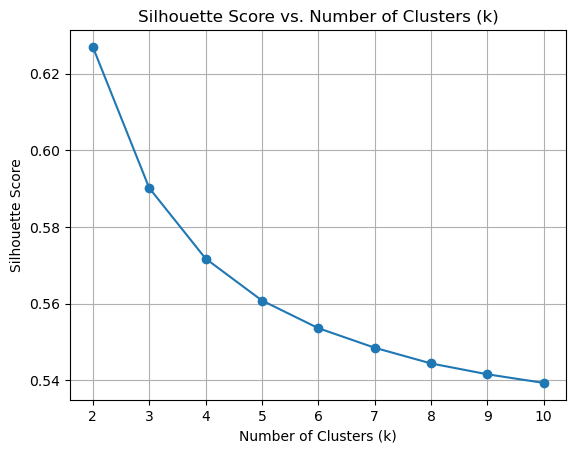

In [42]:
# Визуализируйте силуэтное значение каждой модели
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters (k)')
plt.grid(True)
plt.show()

  0%|                                                                                              | 0/2 [00:00<?, ?it/s]/Users/dan/miniconda3/envs/mlops_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
 50%|████████████████████████████████████████                                        | 1/2 [1:47:59<1:47:59, 6479.82s/it]/Users/dan/miniconda3/envs/mlops_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [3:37:06<00:00, 6513.39s/it]


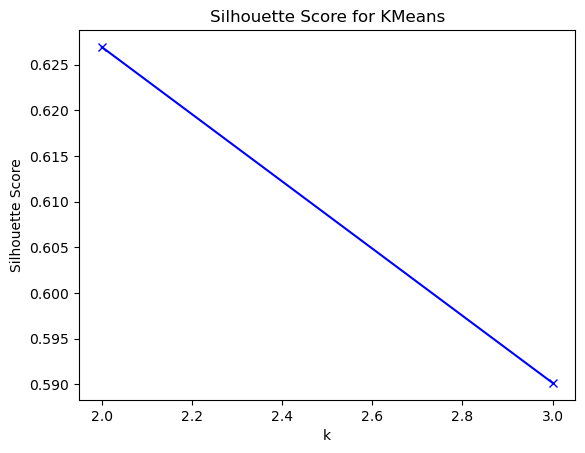

In [45]:
sil = []
K = range(2,4)
for k in tqdm(K):
   kmeans = KMeans(n_clusters=k).fit(users)
   labels = kmeans.labels_
   sil.append(silhouette_score(users, labels, metric = 'euclidean'))

plt.plot(K, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for KMeans')
plt.show()

# Анализ кластеров

In [28]:
model = models[-1]
users['10_clusters'] = model.labels_

In [62]:
model = models[2]
us_it['4_clusters'] = model.labels_

In [484]:
model = models[5]
users['7_clusters'] = model.labels_

In [485]:
us_it = users.merge(interactions[interactions['watched_pct']>80][['user_id', 'item_id']], how='inner', on='user_id')

In [613]:
us_it_items = us_it.merge(items[['item_id', 'genres', 'content_type', 'title', 'release_year']], how='inner', on='item_id')

___разметка жанров___

In [614]:
total_str = ''
for row in range(len(items)):
    total_str = total_str + ',' + items['genres'][row]

total_str = total_str.replace(', ', ',')
total_str = total_str.replace('дорамы', 'драмы')
total_str = total_str.replace('фильмы hbo', 'hbo')
total_str = total_str.replace('русские мультфильмы', 'мультфильмы')
total_str = total_str.replace('сериалы', 'иное')
total_str = total_str.replace('мультфильм', 'мультфильмы')
total_str = total_str.replace('юмор', 'комедии')
total_str = total_str.replace('футбол', 'спорт')
total_str = total_str.replace('концерт', 'музыкальные')
total_str = total_str.replace('мюзиклы', 'музыкальные')
total_str = total_str.replace('фильмы', 'иное')
total_str = total_str.replace('караоке', 'музыкальные')
total_str = total_str.replace('западные мультфильмы', 'мультфильмы')
total_str = total_str.replace('по комиксам', 'иное')
total_str = total_str.replace('аниме', 'иное')
total_str = total_str.replace('для детей', 'мультфильмы')
total_str = total_str.replace('зарубежные', 'иное')
total_str = total_str.replace('фитнес', 'спорт')
total_str = total_str.replace('биография', 'исторические')
total_str = total_str.replace('русские', 'иное')
total_str = total_str.replace('популярное', 'иное')
total_str = total_str.replace('научно-популярные', 'развитие')
total_str = total_str.replace('экранизации', 'иное')
total_str = total_str.replace('фэнтези', 'фантастика')
total_str = total_str.replace('единоборства', 'спорт')
total_str = total_str.replace('охота и рыбалка', 'спорт')
total_str = total_str.replace('караоке', 'музыкальные')
total_str = total_str.replace('образование', 'развитие')
total_str = total_str.replace('18+', 'для взрослых')
total_str = total_str.replace('детские песни', 'музыкальные')

In [615]:
# Уникальные жанры
distinct_genre = list(set(total_str.split(',')[1:]))

___Определим жанры, которые дропнем___

In [616]:
# заготовка по анализ жанров
try_genres = us_it_items[['user_id', 'genres']].copy()

In [617]:
# для каждого жанра создадим свлю колонку и разметим ее
for col in tqdm(distinct_genre):
    try_genres[col] = [1 if col in y else 0 for y in try_genres['genres']]

100%|████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:29<00:00,  2.39it/s]


In [618]:
# Посчитаем для каждого жанра кол-во вхождений
total_genre_sum = try_genres.iloc[:, 2:].sum()
total_genre_sum.sort_values()

иное-спектакли              0
кулинария                   0
передачи                    0
токшоу                      0
западные мультиноеы         0
                        ...  
боевики                381509
приключения            392751
триллеры               433821
комедии                479807
драмы                  693884
Length: 71, dtype: int64

In [619]:
# Соберем редкие жанры так, что бы отсалось 30 основных
bad_columns = total_genre_sum.sort_values()[total_genre_sum.sort_values() <= 200].index
len(bad_columns)

42

In [620]:
distinct_genre = list(set([x if x not in bad_columns else 'иное' for x in distinct_genre]))
len(distinct_genre)

30

In [621]:
distinct_genre

['полнометражные',
 'музыкальные',
 'спорт',
 'ужасы',
 'драмы',
 'развитие',
 'фантастика',
 'триллеры',
 'вестерн',
 'приключения',
 'музыка',
 'мистика',
 'мелодрамы',
 'для взрослых',
 'детективы',
 'советские',
 'детские',
 'боевики',
 'историческое',
 'семейное',
 'комедии',
 'криминал',
 'короткометражные',
 'hbo',
 'развлекательные',
 'документальное',
 'мультфильмы',
 'военные',
 'исторические',
 'иное']

In [495]:
#е = us_it_items.copy()
#us_it_items = е.copy()

In [622]:
# для жанров из топ 30 создадим свлю колонку и разметим ее (без иное)
for col in tqdm(distinct_genre):
    us_it_items[col] = [1 if col in y else 0 for y in us_it_items['genres']]

# Для жанра иное создадим 1 колонку и разметим ее
#us_it_items['иное'] = 0
for col in tqdm(bad_columns):
    us_it_items['иное'] = [ 1 if col in y else x for x, y in zip(us_it_items['иное'], us_it_items['genres']) ]

100%|████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:23<00:00,  1.80it/s]


In [623]:
# Итоговые жанры
total_genre_sum = us_it_items.iloc[:, 21:].sum()
total_genre_sum.sort_values().index

Index(['детские', 'hbo', 'короткометражные', 'развитие', 'для взрослых',
       'мистика', 'полнометражные', 'развлекательные', 'советские', 'иное',
       'исторические', 'мультфильмы', 'вестерн', 'музыкальные', 'музыка',
       'документальное', 'спорт', 'историческое', 'семейное', 'ужасы',
       'военные', 'криминал', 'детективы', 'мелодрамы', 'фантастика',
       'боевики', 'приключения', 'триллеры', 'комедии', 'драмы'],
      dtype='object')

## 10 кластеров

In [29]:
users['10_clusters'].value_counts()

10_clusters
3    85565
2    85519
7    85151
1    84941
5    84783
9    83702
4    83624
8    83218
0    82374
6    81320
Name: count, dtype: int64

In [47]:
us_it['item_id'].value_counts()

item_id
13865    57395
9728     52966
15297    41797
10440    37340
3734     36655
         ...  
941          1
8485         1
9338         1
214          1
11021        1
Name: count, Length: 11119, dtype: int64

In [52]:
dict_top_10 = dict()
dict_top_10_20 = dict()
dict_top_20_30 = dict()
dict_top_30_40 = dict()
dict_top_40_50 = dict()


for cluster in us_it['10_clusters'].unique():
    iter_df = us_it[us_it['10_clusters']==cluster][['item_id']]
    top_10 = iter_df['item_id'].value_counts()[:10].index
    top_10_20 = iter_df['item_id'].value_counts()[10:20].index
    top_20_30 = iter_df['item_id'].value_counts()[20:30].index
    top_30_40 = iter_df['item_id'].value_counts()[30:40].index
    top_40_50 = iter_df['item_id'].value_counts()[40:50].index



    dict_top_10[cluster] = top_10
    dict_top_10_20[cluster] = top_10_20
    dict_top_20_30[cluster] = top_20_30
    dict_top_30_40[cluster] = top_30_40
    dict_top_40_50[cluster] = top_40_50

In [50]:
dict_top_10

{0: Index([13865, 9728, 15297, 10440, 3734, 142, 4151, 8636, 11237, 6809], dtype='int64', name='item_id'),
 5: Index([13865, 9728, 15297, 3734, 10440, 142, 4151, 8636, 11237, 6809], dtype='int64', name='item_id'),
 6: Index([13865, 9728, 15297, 10440, 3734, 142, 4151, 8636, 11237, 6809], dtype='int64', name='item_id'),
 8: Index([13865, 9728, 15297, 10440, 3734, 4151, 142, 8636, 11237, 6809], dtype='int64', name='item_id'),
 9: Index([13865, 9728, 15297, 10440, 3734, 142, 4151, 8636, 11237, 6809], dtype='int64', name='item_id'),
 2: Index([13865, 9728, 15297, 10440, 3734, 4151, 142, 8636, 11237, 6809], dtype='int64', name='item_id'),
 7: Index([13865, 9728, 15297, 10440, 3734, 142, 4151, 8636, 11237, 6809], dtype='int64', name='item_id'),
 1: Index([13865, 9728, 15297, 10440, 3734, 142, 4151, 8636, 11237, 6809], dtype='int64', name='item_id'),
 3: Index([13865, 9728, 15297, 10440, 3734, 142, 4151, 8636, 11237, 6809], dtype='int64', name='item_id'),
 4: Index([13865, 9728, 15297, 3734, 

In [49]:
dict_top_10_20

{0: Index([1844, 7571, 4457, 7417, 14431, 4495, 4740, 4436, 1819, 7626], dtype='int64', name='item_id'),
 5: Index([1844, 7571, 4457, 7417, 14431, 4495, 4740, 4436, 12995, 1819], dtype='int64', name='item_id'),
 6: Index([1844, 7571, 7417, 4457, 14431, 4495, 4740, 4436, 1819, 12995], dtype='int64', name='item_id'),
 8: Index([7571, 1844, 7417, 4457, 14431, 4495, 4740, 4436, 14741, 1819], dtype='int64', name='item_id'),
 9: Index([1844, 7571, 7417, 14431, 4457, 4436, 4740, 4495, 7626, 12995], dtype='int64', name='item_id'),
 2: Index([7571, 1844, 14431, 7417, 4457, 4495, 4436, 4740, 7626, 14703], dtype='int64', name='item_id'),
 7: Index([1844, 7571, 14431, 7417, 4457, 4495, 4740, 4436, 14703, 12995], dtype='int64', name='item_id'),
 1: Index([1844, 7571, 7417, 14431, 4457, 4495, 4436, 4740, 12995, 1819], dtype='int64', name='item_id'),
 3: Index([1844, 7571, 4457, 7417, 14431, 4740, 4495, 4436, 1819, 14703], dtype='int64', name='item_id'),
 4: Index([1844, 7571, 7417, 14431, 4457, 4495

In [51]:
dict_top_20_30

{0: Index([12995, 14703, 12173, 7102, 14741, 16166, 3182, 15464, 14317, 7829], dtype='int64', name='item_id'),
 5: Index([7626, 14703, 14741, 16166, 7102, 12173, 14317, 3182, 5693, 15464], dtype='int64', name='item_id'),
 6: Index([14703, 7626, 12173, 14741, 14317, 7829, 3182, 9169, 15464, 7102], dtype='int64', name='item_id'),
 8: Index([7626, 14703, 12173, 7102, 12995, 16166, 3182, 13018, 15464, 14317], dtype='int64', name='item_id'),
 9: Index([14703, 1819, 12173, 14741, 16166, 3182, 15464, 14317, 7102, 9169], dtype='int64', name='item_id'),
 2: Index([12995, 14741, 1819, 16166, 15464, 3182, 7102, 12173, 14317, 7829], dtype='int64', name='item_id'),
 7: Index([1819, 7626, 7829, 12173, 16166, 3182, 7102, 14741, 14317, 9169], dtype='int64', name='item_id'),
 1: Index([14703, 12173, 7626, 14741, 16166, 3182, 15464, 13018, 5693, 7102], dtype='int64', name='item_id'),
 3: Index([7626, 16166, 14741, 12995, 12173, 7102, 15464, 3182, 14317, 9169], dtype='int64', name='item_id'),
 4: Index([

In [54]:
dict_top_30_40

{0: Index([9169, 5693, 3784, 9996, 3935, 13018, 1287, 11778, 12501, 12981], dtype='int64', name='item_id'),
 5: Index([7829, 3935, 12501, 9169, 9996, 13018, 11778, 1287, 3784, 12981], dtype='int64', name='item_id'),
 6: Index([16166, 9996, 13018, 657, 12981, 12501, 3935, 1287, 11778, 5693], dtype='int64', name='item_id'),
 8: Index([5693, 11778, 7829, 9996, 9169, 3784, 12501, 12981, 3935, 5658], dtype='int64', name='item_id'),
 9: Index([7829, 5693, 13018, 12501, 9996, 12981, 3935, 657, 11778, 3784], dtype='int64', name='item_id'),
 2: Index([9169, 12501, 5693, 3784, 9996, 13018, 11778, 657, 12981, 5658], dtype='int64', name='item_id'),
 7: Index([9996, 13018, 15464, 11778, 3784, 3935, 5693, 12981, 12501, 1287], dtype='int64', name='item_id'),
 1: Index([9169, 9996, 14317, 7829, 3935, 11778, 3784, 1287, 12501, 12981], dtype='int64', name='item_id'),
 3: Index([7829, 12981, 3784, 9996, 13018, 3935, 5693, 11778, 12501, 5658], dtype='int64', name='item_id'),
 4: Index([7829, 5693, 13018, 

In [58]:
dict_top_40_50

{0: Index([5658, 657, 11310, 10772, 14461, 5411, 1785, 6626, 512, 12841], dtype='int64', name='item_id'),
 5: Index([5658, 657, 11310, 10772, 11754, 13915, 7582, 16270, 14461, 10942], dtype='int64', name='item_id'),
 6: Index([3784, 11310, 5658, 10772, 14461, 16270, 13915, 11754, 849, 8618], dtype='int64', name='item_id'),
 8: Index([11310, 657, 1287, 10772, 849, 11754, 14461, 10942, 7582, 5411], dtype='int64', name='item_id'),
 9: Index([11310, 1287, 5658, 10772, 7582, 6626, 16270, 849, 11754, 8618], dtype='int64', name='item_id'),
 2: Index([3935, 11310, 10772, 1287, 14461, 6626, 11754, 7582, 16270, 849], dtype='int64', name='item_id'),
 7: Index([657, 5658, 11310, 10772, 849, 13915, 14461, 6626, 16270, 8618], dtype='int64', name='item_id'),
 1: Index([5658, 657, 10772, 14461, 11310, 7582, 13915, 6626, 10942, 1785], dtype='int64', name='item_id'),
 3: Index([657, 1287, 10772, 849, 11310, 14461, 6626, 16270, 10464, 7582], dtype='int64', name='item_id'),
 4: Index([12501, 657, 12981, 1

## 4 Кластера

In [65]:
us_it['4_clusters'].value_counts()

4_clusters
0    210714
1    210155
2    209992
3    209336
Name: count, dtype: int64

In [68]:
dict_4c_top_10 = dict()
dict_4c_top_10_20 = dict()
dict_4c_top_20_30 = dict()
dict_4c_top_30_40 = dict()
dict_4c_top_40_50 = dict()


for cluster in us_it['4_clusters'].unique():
    iter_df = us_it[us_it['4_clusters']==cluster][['item_id']]
    top_10 = iter_df['item_id'].value_counts()[:10].index
    top_10_20 = iter_df['item_id'].value_counts()[10:20].index
    top_20_30 = iter_df['item_id'].value_counts()[20:30].index
    top_30_40 = iter_df['item_id'].value_counts()[30:40].index
    top_40_50 = iter_df['item_id'].value_counts()[40:50].index



    dict_4c_top_10[cluster] = top_10
    dict_4c_top_10_20[cluster] = top_10_20
    dict_4c_top_20_30[cluster] = top_20_30
    dict_4c_top_30_40[cluster] = top_30_40
    dict_4c_top_40_50[cluster] = top_40_50

In [75]:
print('dict_4c_top_10')
dict_4c_top_10

dict_4c_top_10


{0: Index([13865, 9728, 15297, 10440, 3734, 142, 4151, 8636, 11237, 6809], dtype='int64', name='item_id'),
 2: Index([13865, 9728, 15297, 10440, 3734, 142, 4151, 8636, 11237, 6809], dtype='int64', name='item_id'),
 1: Index([13865, 9728, 15297, 10440, 3734, 4151, 142, 8636, 11237, 6809], dtype='int64', name='item_id'),
 3: Index([13865, 9728, 15297, 10440, 3734, 142, 4151, 8636, 11237, 6809], dtype='int64', name='item_id')}

In [74]:
print('dict_4c_top_10_20')
dict_4c_top_10_20

dict_4c_top_10_20


{0: Index([1844, 7571, 7417, 4457, 14431, 4495, 4740, 4436, 1819, 12995], dtype='int64', name='item_id'),
 2: Index([1844, 7571, 4457, 7417, 14431, 4495, 4740, 4436, 7626, 14703], dtype='int64', name='item_id'),
 1: Index([1844, 7571, 7417, 14431, 4457, 4495, 4436, 4740, 12995, 1819], dtype='int64', name='item_id'),
 3: Index([1844, 7571, 4457, 14431, 7417, 4495, 4740, 4436, 14703, 1819], dtype='int64', name='item_id')}

In [73]:
print('dict_4c_top_20_30')
dict_4c_top_20_30

dict_4c_top_20_30


{0: Index([7626, 14703, 14741, 12173, 16166, 7102, 15464, 3182, 7829, 14317], dtype='int64', name='item_id'),
 2: Index([12995, 1819, 14741, 7102, 12173, 16166, 3182, 15464, 14317, 5693], dtype='int64', name='item_id'),
 1: Index([14703, 7626, 14741, 12173, 16166, 3182, 14317, 9169, 7102, 15464], dtype='int64', name='item_id'),
 3: Index([12995, 7626, 16166, 12173, 14741, 7102, 7829, 3182, 15464, 9169], dtype='int64', name='item_id')}

In [72]:
print('dict_4c_top_30_40')
dict_4c_top_30_40

dict_4c_top_30_40


{0: Index([9169, 9996, 13018, 5693, 3784, 11778, 3935, 12501, 12981, 1287], dtype='int64', name='item_id'),
 2: Index([7829, 13018, 9996, 9169, 12501, 11778, 3784, 3935, 657, 12981], dtype='int64', name='item_id'),
 1: Index([7829, 13018, 5693, 9996, 3935, 11778, 1287, 3784, 12501, 12981], dtype='int64', name='item_id'),
 3: Index([14317, 9996, 13018, 3784, 5693, 3935, 11778, 12981, 12501, 1287], dtype='int64', name='item_id')}

In [71]:
print('dict_4c_top_40_50')
dict_4c_top_40_50

dict_4c_top_40_50


{0: Index([657, 5658, 11310, 10772, 14461, 5411, 16270, 849, 6626, 13915], dtype='int64', name='item_id'),
 2: Index([1287, 5658, 11310, 10772, 11754, 14461, 7582, 849, 16270, 6626], dtype='int64', name='item_id'),
 1: Index([657, 10772, 5658, 11310, 7582, 16270, 11754, 849, 8618, 6626], dtype='int64', name='item_id'),
 3: Index([5658, 657, 10772, 11310, 849, 14461, 6626, 13915, 16270, 10942], dtype='int64', name='item_id')}

## 7 clusters

In [84]:
us_it['7_clusters'].value_counts()

7_clusters
6    224480
1    222242
4    220529
0    219111
3    217469
2    216421
5    213055
Name: count, dtype: int64

In [85]:
dict_7c_top_10 = dict()
dict_7c_top_10_20 = dict()
dict_7c_top_20_30 = dict()
dict_7c_top_30_40 = dict()
dict_7c_top_40_50 = dict()


for cluster in us_it['7_clusters'].unique():
    iter_df = us_it[us_it['7_clusters']==cluster][['item_id']]
    top_10 = iter_df['item_id'].value_counts()[:10].index
    top_10_20 = iter_df['item_id'].value_counts()[10:20].index
    top_20_30 = iter_df['item_id'].value_counts()[20:30].index
    top_30_40 = iter_df['item_id'].value_counts()[30:40].index
    top_40_50 = iter_df['item_id'].value_counts()[40:50].index

    dict_7c_top_10[cluster] = top_10
    dict_7c_top_10_20[cluster] = top_10_20
    dict_7c_top_20_30[cluster] = top_20_30
    dict_7c_top_30_40[cluster] = top_30_40
    dict_7c_top_40_50[cluster] = top_40_50

In [89]:
dict_7c_top_10

{5: Index([13865, 9728, 15297, 10440, 3734, 142, 4151, 8636, 11237, 6809], dtype='int64', name='item_id'),
 3: Index([13865, 9728, 15297, 10440, 3734, 142, 4151, 8636, 11237, 1844], dtype='int64', name='item_id'),
 2: Index([13865, 9728, 15297, 10440, 3734, 142, 4151, 8636, 11237, 6809], dtype='int64', name='item_id'),
 1: Index([13865, 9728, 15297, 3734, 10440, 4151, 142, 8636, 11237, 6809], dtype='int64', name='item_id'),
 0: Index([13865, 9728, 15297, 10440, 3734, 142, 8636, 4151, 11237, 6809], dtype='int64', name='item_id'),
 4: Index([13865, 9728, 15297, 10440, 3734, 142, 4151, 8636, 11237, 6809], dtype='int64', name='item_id'),
 6: Index([13865, 9728, 15297, 10440, 3734, 142, 4151, 8636, 11237, 6809], dtype='int64', name='item_id')}

In [90]:
dict_7c_top_10_20

{5: Index([1844, 7571, 4457, 7417, 14431, 4495, 4740, 4436, 1819, 12995], dtype='int64', name='item_id'),
 3: Index([6809, 7571, 4457, 7417, 14431, 4495, 4740, 4436, 7626, 12995], dtype='int64', name='item_id'),
 2: Index([7571, 1844, 4457, 14431, 7417, 4495, 4740, 4436, 1819, 14741], dtype='int64', name='item_id'),
 1: Index([1844, 7571, 7417, 14431, 4457, 4495, 4436, 4740, 12995, 14703], dtype='int64', name='item_id'),
 0: Index([7571, 1844, 7417, 14431, 4457, 4495, 4740, 4436, 14703, 7626], dtype='int64', name='item_id'),
 4: Index([1844, 7571, 14431, 4457, 7417, 4495, 4740, 4436, 12995, 14703], dtype='int64', name='item_id'),
 6: Index([1844, 7571, 7417, 14431, 4457, 4495, 4740, 4436, 1819, 14703], dtype='int64', name='item_id')}

In [91]:
dict_7c_top_20_30

{5: Index([7626, 14703, 12173, 14741, 14317, 7829, 3182, 7102, 9169, 15464], dtype='int64', name='item_id'),
 3: Index([1819, 14703, 14741, 12173, 7102, 16166, 3182, 14317, 5693, 15464], dtype='int64', name='item_id'),
 2: Index([14703, 12995, 7102, 7626, 16166, 12173, 15464, 3182, 7829, 14317], dtype='int64', name='item_id'),
 1: Index([1819, 14741, 7626, 12173, 16166, 14317, 7102, 9169, 3182, 15464], dtype='int64', name='item_id'),
 0: Index([16166, 14741, 1819, 12995, 15464, 7102, 12173, 3182, 14317, 7829], dtype='int64', name='item_id'),
 4: Index([1819, 7626, 12173, 16166, 7829, 3182, 14741, 7102, 14317, 9169], dtype='int64', name='item_id'),
 6: Index([12995, 7626, 12173, 14741, 16166, 3182, 15464, 7102, 9169, 5693], dtype='int64', name='item_id')}

In [92]:
dict_7c_top_30_40

{5: Index([16166, 9996, 13018, 5693, 12981, 11778, 657, 3784, 3935, 12501], dtype='int64', name='item_id'),
 3: Index([9996, 9169, 13018, 7829, 3935, 12501, 11778, 3784, 1287, 12981], dtype='int64', name='item_id'),
 2: Index([13018, 5693, 3784, 9169, 9996, 11778, 12501, 3935, 1287, 12981], dtype='int64', name='item_id'),
 1: Index([7829, 5693, 13018, 9996, 3784, 1287, 10772, 11778, 3935, 5658], dtype='int64', name='item_id'),
 0: Index([9169, 12501, 3784, 5693, 13018, 9996, 11778, 12981, 3935, 5658], dtype='int64', name='item_id'),
 4: Index([15464, 9996, 13018, 3784, 11778, 3935, 5693, 12981, 1287, 12501], dtype='int64', name='item_id'),
 6: Index([13018, 7829, 14317, 3935, 9996, 11778, 12501, 12981, 1287, 657], dtype='int64', name='item_id')}

In [93]:
dict_7c_top_40_50

{5: Index([1287, 5658, 11310, 10772, 14461, 16270, 12841, 5411, 11754, 1785], dtype='int64', name='item_id'),
 3: Index([657, 5658, 11310, 10772, 7582, 14461, 13915, 11754, 10942, 1785], dtype='int64', name='item_id'),
 2: Index([5658, 11310, 657, 10772, 14461, 849, 5411, 10942, 11754, 6626], dtype='int64', name='item_id'),
 1: Index([657, 12501, 12981, 11310, 7582, 8618, 11754, 16270, 849, 12841], dtype='int64', name='item_id'),
 0: Index([657, 10772, 11310, 1287, 849, 16270, 14461, 6626, 11754, 10464], dtype='int64', name='item_id'),
 4: Index([11310, 5658, 657, 10772, 14461, 849, 13915, 6626, 16270, 14359], dtype='int64', name='item_id'),
 6: Index([3784, 5658, 11310, 10772, 14461, 6626, 7582, 13915, 11754, 16270], dtype='int64', name='item_id')}

### title 7 clusters

In [120]:
dict_7c_top_10 = dict()
dict_7c_top_10_20 = dict()
dict_7c_top_20_30 = dict()
dict_7c_top_30_40 = dict()
dict_7c_top_40_50 = dict()


for cluster in us_it_items['7_clusters'].unique():
    iter_df = us_it_items[us_it['7_clusters']==cluster][['title']]
    iter_df = iter_df.value_counts('title')
    top_10 = iter_df[:10].index
    top_10_20 = iter_df[10:20].index
    top_20_30 = iter_df[20:30].index
    top_30_40 = iter_df[30:40].index
    top_40_50 = iter_df[40:50].index

    dict_7c_top_10[cluster] = top_10
    dict_7c_top_10_20[cluster] = top_10_20
    dict_7c_top_20_30[cluster] = top_20_30
    dict_7c_top_30_40[cluster] = top_30_40
    dict_7c_top_40_50[cluster] = top_40_50

In [122]:
dict_7c_top_10

{5: Index(['Девятаев', 'Гнев человеческий', 'Клиника счастья', 'Хрустальный',
        'Прабабушка легкого поведения', 'Секреты семейной жизни', 'Белый снег',
        'Маша', 'День города', '100% волк'],
       dtype='object', name='title'),
 4: Index(['Девятаев', 'Гнев человеческий', 'Клиника счастья', 'Хрустальный',
        'Прабабушка легкого поведения', 'Секреты семейной жизни', 'Белый снег',
        'Маша', 'День города', 'Дуров'],
       dtype='object', name='title'),
 6: Index(['Девятаев', 'Гнев человеческий', 'Клиника счастья', 'Хрустальный',
        'Прабабушка легкого поведения', 'Маша', 'Секреты семейной жизни',
        'Белый снег', 'День города', 'Дуров'],
       dtype='object', name='title'),
 0: Index(['Девятаев', 'Гнев человеческий', 'Клиника счастья',
        'Прабабушка легкого поведения', 'Хрустальный', 'Маша',
        'Секреты семейной жизни', 'Белый снег', '100% волк', 'День города'],
       dtype='object', name='title'),
 3: Index(['Девятаев', 'Гнев человеческий', 

In [121]:
dict_7c_top_10_20

{5: Index(['Дуров', 'Аферистка', 'Приворот. Чёрное венчание',
        '2067: Петля времени', 'Сахаров. Две жизни', 'Стендап под прикрытием',
        'Пальмира', 'Ford против Ferrari', 'Веном', 'Зверополис'],
       dtype='object', name='title'),
 4: Index(['Аферистка', '100% волк', '2067: Петля времени', 'Пальмира',
        'Восемь сотен', 'Приворот. Чёрное венчание', 'Стендап под прикрытием',
        'Взаперти', 'Ford против Ferrari', 'Апгрейд'],
       dtype='object', name='title'),
 6: Index(['100% волк', 'Аферистка', 'Приворот. Чёрное венчание',
        '2067: Петля времени', 'Стендап под прикрытием', 'Пальмира',
        'Ford против Ferrari', 'Восемь сотен', 'Сахаров. Две жизни',
        'Мстители: Финал'],
       dtype='object', name='title'),
 0: Index(['Аферистка', 'Дуров', 'Стендап под прикрытием', '2067: Петля времени',
        'Ford против Ferrari', 'Приворот. Чёрное венчание', 'Пальмира',
        'Сахаров. Две жизни', 'Цвет из иных миров', 'Денежная игла'],
       dtype='ob

In [114]:
us_it_items[us_it_items['7_clusters'] == 5].value_counts('title')[:10].index

Index(['Девятаев', 'Гнев человеческий', 'Клиника счастья', 'Хрустальный',
       'Прабабушка легкого поведения', 'Маша', 'Секреты семейной жизни',
       'Белый снег', 'День города', 'Дуров'],
      dtype='object', name='title')

# USE IT !

In [537]:
e = us_it_items.copy()

In [624]:
us_it_items = us_it_items.drop([
    'kids_flg', 'gender_man_flg', 'age_age_18_24', 'age_age_25_34', 'age_age_35_44', 'age_age_45_54', 'age_age_55_64', 
    'age_age_65_inf', 'income_income_0_20', 'income_income_150_inf', 'income_income_20_40', 'income_income_40_60', 
    'income_income_60_90', 'income_income_90_150', 'user_id'
], axis=1)

In [625]:
us_it_items

,7_clusters,item_id,genres,content_type,title,release_year,полнометражные,музыкальные,спорт,ужасы,драмы,развитие,фантастика,триллеры,вестерн,приключения,музыка,мистика,мелодрамы,для взрослых,детективы,советские,детские,боевики,историческое,семейное,комедии,криминал,короткометражные,hbo,развлекательные,документальное,мультфильмы,военные,исторические,иное
0,5,12204,"боевики, драмы, триллеры",film,Город порока,2012.0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,3,12204,"боевики, драмы, триллеры",film,Город порока,2012.0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,1,12204,"боевики, драмы, триллеры",film,Город порока,2012.0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,12204,"боевики, драмы, триллеры",film,Город порока,2012.0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,12204,"боевики, драмы, триллеры",film,Город порока,2012.0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1533302,2,5834,"драмы, вестерн",film,Однажды на Диком Западе,1968.0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1533303,4,11318,драмы,film,Подделка,2018.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1533304,6,15897,"драмы, зарубежные, триллеры, приключения",film,Черное море,2014.0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1533305,6,5379,"фантастика, драмы, зарубежные, мелодрамы",film,Последняя женщина на Земле (с тифлокомментарием),2019.0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [392]:
def create_score_df(age: str, income: str, sex: str, kids_flg: int) -> pd.DataFrame:
    '''Функция принимает на вход данные от пользователя (черех ТГ бота) 

    Пользователь вводит информацию о себе используя кнопки в телеграмме (фиксированные ответы):
    age: 'age_18_24', 'age_25_34', 'age_45_54', 'age_35_44', 'age_55_64', 'age_65_inf'
    income: 'income_0_20', 'income_20_40', 'income_40_60', 'income_60_90', 'income_90_150', 'income_150_inf'
    sex: 'М', 'Ж'
    kids_flg: 1, 0

    Далее происходит
        * Формирование DF
        * Преобразование бинарного столбца sex
        * OHE кодирование

    На выходе получаемм готовый DF для кластеризации
    '''

    ############ Формирование DF
    input_user_df = pd.DataFrame({
        'user_id' : [-1],
        'age' : [age],
        'income' : [income],
        'sex' : [sex],
        'kids_flg' : [kids_flg]
    })

    ############ Преобразование бинарного столбца sex
    input_user_df['gender_man_flg'] = input_user_df['sex'].apply(lambda x: 1 if x=='М' else 0)
    input_user_df = input_user_df.drop('sex', axis=1)

    ############ OHE кодирование
    encoder_input_df = encoder.transform(input_user_df[encod_features])[0] # ohe np array
    df_for_score_input = pd.DataFrame(columns=encoder.get_feature_names_out()) # ohe df (only columns)
    df_for_score_input.loc[0] = encoder_input_df # ohe df add data

    # Заменим категориальные фичи на новые бинаризованные.
    input_user_df = pd.concat([input_user_df.drop(encod_features, axis=1), df_for_score_input], axis=1)

    return input_user_df

In [559]:
def data_find_best_content(
    data_to_score:pd.DataFrame = input_user_df, 
    genre:str = 'ужасы', 
    content_type:str = 'film',
    us_it_items:pd.DataFrame = us_it_items,
    model = model) -> pd.Series:
    '''Функция получает на вход информацию о клиенте, пожеланиях и на основе этого возвращает фильмы (рекомендации)

    Пользователь вводит информацию о пожеланиях используя кнопки в телеграмме (фиксированные ответы), а так же ранее агрегированные данные:
    genre: 'ужасы', 'боевики' и тд
    content_type: 'series' 'film'
    
    data_to_score - это данные полученные из функции create_score_df
    us_it_items - это датасет с информацией о кластере клиента и фильмах которые он смотрел. На основе него агрегируем
    информацию о популярности фильмов
    model - моделькластеризации

    Далее происходит
        * Выбираем кластер для клиента
        * Формируем DF с фильмами на основе пожеланий клиента. Ранжируем фильмы по "кол-ву просмотров"
        * OHE кодирование
        
    На выходе pd.Series, где индексы - это item_id, расположенные по популярности у пользователей из этого же кластера
    по этим же предпосчтениям (если они указаны)
    '''
    ############# Выбираем кластер для клиента

    data_to_score = data_to_score[model.feature_names_in_] #Данные для кластеризации
    predict_cluster = model.predict(data_to_score)[0] #Определяем кластер

    ############# Формируем DF с фильмами на основе пожеланий клиента. Ранжируем фильмы по "кол-ву просмотров" 
    if (genre is None) & (content_type is None): # Если жанр и тип контента пропуски
        pass
    elif (genre is None) & (content_type is not None): # Если жанр пропуск и тип контента заполнен
        best_films_for_user = us_it_items[
            (us_it_items['7_clusters']==predict_cluster) & (us_it_items['content_type']==f'{content_type}')
        ]['item_id'].value_counts()
    elif (genre is not None) & (content_type is None): # Если жанр заполнен и тип контента пропуск
        best_films_for_user = us_it_items[
            (us_it_items['7_clusters']==predict_cluster) & (us_it_items[genre]==1)
        ]['item_id'].value_counts() 
    else: # Если все заполнено
        best_films_for_user = us_it_items[
            (us_it_items['7_clusters']==predict_cluster) & (us_it_items[genre]==1) & (us_it_items['content_type']==f'{content_type}')
        ]['item_id'].value_counts()

    return best_films_for_user

In [542]:
def show_recommendations(best_films_for_user:pd.Series = best_films_for_user):
    input_val = 'next' 
    start = 0 # Стартовый номер рекмендации на 1 иетрации (индекс)
    stop = 10 # Последний номер рекмендации на 1 иетрации (индекс)
    i = 1 # Порядковый номер рекомендации
    
    while input_val == 'next':
       
        recomendet_film = best_films_for_user[start:stop].index
        
        if start == 0:
            print(f'Составляем рекомендации на основе похожих на вас пользователей...')
        
        # Навесим на id рекомендуемых фильмов инфу из items
        df_to_show_index = pd.DataFrame(recomendet_film, columns=['item_id'])
        df_to_show = items.merge(df_to_show_index, how='inner', on='item_id')
    
        # Выводим контент
        if len(best_films_for_user) > start: # Пока есть контент - выведем его 
            print(f'Рекомендуем посмотреть следущие фильмы: ')
            
            for film in recomendet_film: # Итерируемся по каждому фильму
                # Собираем инфу о фильме в переменные
                rec = df_to_show[df_to_show['item_id']==film][['title', 'release_year', 'genres', 'content_type']]
                if content_type == 'film':
                    content = 'Фильм'
                else:
                    content = 'Сериал'
                year_show = int(rec['release_year'].iloc[0])
                title_show = rec['title'].iloc[0]
                genres_show = rec['genres'].iloc[0]
    
                # Выводим контент
                print(f'{i}. {content}: {title_show}, год выпуска: {year_show}, жанр: {genres_show}')
                i = i + 1
        else:
            print('Больше подходящего контента у нас нет :( попробуйте изменить критерии поиск')

        # Обновим индексы для следующего отображения
        start = start + 10
        stop = stop + 10

        # Продолжаем или останавливаемя ('next'?) - кнопка из ТГ
        input_val = input('next для следующих рекомендаций: ')

In [626]:
age_input = input("STR: 'age_25_34', 'age_18_24', 'age_45_54', 'age_35_44', 'age_55_64', 'age_65_inf'")
income_input = input("STR: 'income_60_90', 'income_20_40', 'income_40_60', 'income_0_20', 'income_90_150', 'income_150_inf'")
sex_input = input("STR: 'М', 'Ж'")
kids_input = int(input("INT: 1 , 0 "))

# def create_score_df
input_user_df = create_score_df(age=age_input, income=income_input, sex=sex_input, kids_flg=kids_input)

STR: 'age_25_34', 'age_18_24', 'age_45_54', 'age_35_44', 'age_55_64', 'age_65_inf' age_65_inf
STR: 'income_60_90', 'income_20_40', 'income_40_60', 'income_0_20', 'income_90_150', 'income_150_inf' income_60_90
STR: 'М', 'Ж' Ж
INT: 1 , 0  0


In [627]:
# def data_find_best_content
best_films_for_user = data_find_best_content(input_user_df)

In [628]:
# def show_recommendations
show_recommendations(best_films_for_user)

Составляем рекомендации на основе похожих на вас пользователей...
Рекомендуем посмотреть следущие фильмы: 
1. Фильм: Приворот. Чёрное венчание, год выпуска: 2021, жанр: ужасы, триллеры, мелодрамы
2. Фильм: Цвет из иных миров, год выпуска: 2020, жанр: фантастика, ужасы
3. Фильм: Веном, год выпуска: 2018, жанр: популярное, фантастика, триллеры, боевики, ужасы
4. Фильм: Doom: Аннигиляция, год выпуска: 2019, жанр: боевики, ужасы, фантастика, триллеры
5. Фильм: Проклятие ведьмы, год выпуска: 2020, жанр: ужасы
6. Фильм: 13 грехов, год выпуска: 2013, жанр: ужасы, триллеры
7. Фильм: Что скрывает вода, год выпуска: 2020, жанр: ужасы, триллеры
8. Фильм: Брешь, год выпуска: 2020, жанр: боевики, ужасы, фантастика
9. Фильм: С днём смерти, год выпуска: 2020, жанр: ужасы, детективы
10. Фильм: Мы – монстры, год выпуска: 2017, жанр: ужасы, мультфильм, фэнтези, комедии


next для следующих рекомендаций:  f


# Save data

In [630]:
us_it_items.isna().sum().sort_values()

7_clusters          0
детективы           0
советские           0
детские             0
боевики             0
историческое        0
семейное            0
для взрослых        0
комедии             0
короткометражные    0
hbo                 0
развлекательные     0
документальное      0
мультфильмы         0
военные             0
криминал            0
мелодрамы           0
мистика             0
музыка              0
item_id             0
genres              0
content_type        0
title               0
полнометражные      0
музыкальные         0
исторические        0
спорт               0
драмы               0
развитие            0
фантастика          0
триллеры            0
вестерн             0
приключения         0
ужасы               0
иное                0
release_year        7
dtype: int64

In [631]:
mod = us_it_items['release_year'].mode()
us_it_items['release_year'] = us_it_items['release_year'].fillna(mod[0])

In [632]:
us_it_items.isna().sum().sum()

0

In [633]:
us_it_items['item_id'].max()

16518

In [634]:
for col in us_it_items.columns:
    if col not in  ('content_type', 'item_id', 'title', 'genres', 'release_year'):
        us_it_items[col] = us_it_items[col].astype('int8')
        
us_it_items['release_year'] = us_it_items['release_year'].astype('int16')
us_it_items['item_id'] = us_it_items['item_id'].astype('int16')

In [635]:
us_it_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1533307 entries, 0 to 1533306
Data columns (total 36 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   7_clusters        1533307 non-null  int8  
 1   item_id           1533307 non-null  int16 
 2   genres            1533307 non-null  object
 3   content_type      1533307 non-null  object
 4   title             1533307 non-null  object
 5   release_year      1533307 non-null  int16 
 6   полнометражные    1533307 non-null  int8  
 7   музыкальные       1533307 non-null  int8  
 8   спорт             1533307 non-null  int8  
 9   ужасы             1533307 non-null  int8  
 10  драмы             1533307 non-null  int8  
 11  развитие          1533307 non-null  int8  
 12  фантастика        1533307 non-null  int8  
 13  триллеры          1533307 non-null  int8  
 14  вестерн           1533307 non-null  int8  
 15  приключения       1533307 non-null  int8  
 16  музыка            

In [639]:
us_it_items

,7_clusters,item_id,genres,content_type,title,release_year,полнометражные,музыкальные,спорт,ужасы,драмы,развитие,фантастика,триллеры,вестерн,приключения,музыка,мистика,мелодрамы,для взрослых,детективы,советские,детские,боевики,историческое,семейное,комедии,криминал,короткометражные,hbo,развлекательные,документальное,мультфильмы,военные,исторические,иное
0,5,12204,"боевики, драмы, триллеры",film,Город порока,2012,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,3,12204,"боевики, драмы, триллеры",film,Город порока,2012,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,1,12204,"боевики, драмы, триллеры",film,Город порока,2012,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,12204,"боевики, драмы, триллеры",film,Город порока,2012,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,12204,"боевики, драмы, триллеры",film,Город порока,2012,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1533302,2,5834,"драмы, вестерн",film,Однажды на Диком Западе,1968,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1533303,4,11318,драмы,film,Подделка,2018,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1533304,6,15897,"драмы, зарубежные, триллеры, приключения",film,Черное море,2014,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1533305,6,5379,"фантастика, драмы, зарубежные, мелодрамы",film,Последняя женщина на Земле (с тифлокомментарием),2019,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [638]:
us_it_items.to_csv('data_for_rec_model_user_to_user.csv', index=False)

In [521]:
# save model
with open("model_user_to_user.pkl", "wb") as f:
   # Сохраняем объект в файл
   pickle.dump(model, f)

In [522]:
# save encoder
with open("encoder_user_to_user.pkl", "wb") as f:
   # Сохраняем объект в файл
   pickle.dump(encoder, f)

In [524]:
us_it_items

,7_clusters,item_id,content_type,полнометражные,музыкальные,спорт,ужасы,драмы,развитие,фантастика,триллеры,вестерн,приключения,музыка,мистика,мелодрамы,для взрослых,детективы,советские,детские,боевики,историческое,семейное,комедии,криминал,короткометражные,hbo,развлекательные,документальное,мультфильмы,военные,исторические,иное
0,5,-84,film,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,3,-84,film,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,1,-84,film,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,-84,film,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,-84,film,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1533302,2,-54,film,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1533303,4,54,film,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1533304,6,25,film,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1533305,6,3,film,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [597]:
us_it_items.columns

Index(['7_clusters', 'item_id', 'genres', 'content_type', 'title',
       'release_year', 'полнометражные', 'музыкальные', 'спорт', 'реалити-шоу',
       'ужасы', 'драмы', 'живая природа', 'мультиное', 'развитие',
       'фантастика', 'сказки', 'артхаус', 'реалити', 'триллеры', 'передачи',
       'приключения', 'вестерн', 'музыка', 'мультиноеы', 'телешоу', 'мистика',
       'no_genre', 'мировая классика', 'немое кино', 'кулинария', 'мелодрамы',
       'анимация', 'для взрослых', 'детективы', 'тележурналы', 'советские',
       'детские', 'стендап', 'о знаменитостях', 'красота и здоровье',
       'боевики', 'иное-спектакли', 'историческое', 'молодежные',
       'короткий метр', 'комиксы', 'семейное', 'комедии', 'вокруг света',
       'шоу', 'романтика', 'хочу всё знать', 'познавательные', 'ток-шоу',
       'блогер', 'увлечения', 'западные мультиноеы', 'криминал',
       'короткометражные', 'hbo', 'развлекательные', 'медицинские',
       'воспитание детей', 'документальное', 'для самых ма

In [ ]:
''''полнометражные'
'музыкальные'
'спорт'
'реалити-шоу'
'ужасы'
'драмы'
'живая природа'
'мультиное'
'развитие'
'фантастика'
'сказки'
'артхаус'
'реалити'
'триллеры'
'передачи'
'приключения'
'вестерн'
'музыка'
'мультиноеы'
'телешоу'
'мистика'
'no_genre'
'мировая классика'
'немое кино'
'кулинария'
'мелодрамы'
'анимация'
для взрослых'
детективы'
тележурналы'
советские'
детские'
стендап'
о знаменитостях'
красота и здоровье'
боевики'
иное-спектакли'
историческое'
молодежные'
короткий метр'
комиксы'
семейное'
комедии'
вокруг света'
шоу'
романтика'
хочу всё знать'
познавательные'
ток-шоу'
блогер'
увлечения'
западные мультиноеы'
криминал'
короткометражные'
hbo'
развлекательные'
'медицинские'
воспитание детей'
документальное'
для самых маленьких'
токшоу'
фильм-нуар'
мультфильмы'
военные'
исторические'
индийское кино'
иное'
катастрофы'
рекомендуем'
про животных'
интервью'

In [637]:
distinct_genre.sort()
distinct_genre

['hbo',
 'боевики',
 'вестерн',
 'военные',
 'детективы',
 'детские',
 'для взрослых',
 'документальное',
 'драмы',
 'иное',
 'исторические',
 'историческое',
 'комедии',
 'короткометражные',
 'криминал',
 'мелодрамы',
 'мистика',
 'музыка',
 'музыкальные',
 'мультфильмы',
 'полнометражные',
 'приключения',
 'развитие',
 'развлекательные',
 'семейное',
 'советские',
 'спорт',
 'триллеры',
 'ужасы',
 'фантастика']